In [3]:
print("hello")

hello


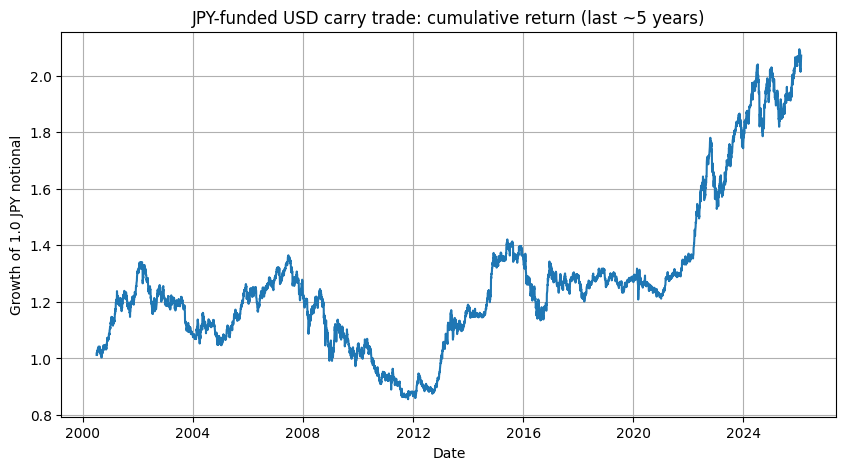

Calendar-year returns (JPY terms):
observation_date
2000     11.01%
2001     18.18%
2002     -8.14%
2003    -10.07%
2004     -2.93%
2005      15.7%
2006      5.65%
2007     -4.67%
2008    -16.08%
2009      1.61%
2010    -11.82%
2011     -5.98%
2012     13.65%
2013      20.4%
2014     14.67%
2015      -0.7%
2016     -1.07%
2017     -3.98%
2018     -1.36%
2019      0.81%
2020     -4.57%
2021     11.79%
2022     14.85%
2023     12.32%
2024     15.07%
2025      2.05%
2026      0.45%
dtype: object


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# --- Parameters ---
end = date.today()
start = end - timedelta(days=365*40 + 10)  # ~5y buffer
start_s = start.isoformat()
end_s = end.isoformat()

def fred_csv(series_id, start_date, end_date):
    url = (
        "https://fred.stlouisfed.org/graph/fredgraph.csv"
        f"?id={series_id}&cosd={start_date}&coed={end_date}"
    )
    df = pd.read_csv(url)

    # FRED uses 'observation_date' in this endpoint
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    df = df.set_index("observation_date")

    # Clean missing values and coerce to numeric
    df = df.replace(".", np.nan)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

# --- Fetch data ---
fx = fred_csv("DEXJPUS", start_s, end_s).rename(columns={"DEXJPUS": "USDJPY"})  # JPY per USD
us = fred_csv("EFFR", start_s, end_s).rename(columns={"EFFR": "r_us"})         # % p.a., daily
jp = fred_csv("IRSTCI01JPM156N", start_s, end_s).rename(columns={"IRSTCI01JPM156N": "r_jp"})  # % p.a., monthly

# --- Align frequencies ---
# Daily calendar from FX (business-day-ish); forward-fill rates.
data = fx.join(us, how="left").join(jp, how="left")
data["r_us"] = data["r_us"].ffill()
data["r_jp"] = data["r_jp"].ffill()

# Drop days where FX is missing (holidays)
data = data.dropna(subset=["USDJPY", "r_us", "r_jp"]).copy()

# --- Carry trade daily return in JPY terms ---
# Use ACT/360 daycount (common for money markets); you can switch to 365 if desired.
dt = 1/360
r_us = data["r_us"] / 100.0
r_jp = data["r_jp"] / 100.0

# FX gross return: S_{t+1}/S_t
fx_gross = data["USDJPY"].shift(-1) / data["USDJPY"]

# Interest gross returns over one day
us_gross = 1 + r_us * dt
jp_gross = 1 + r_jp * dt

gross = fx_gross * (us_gross / jp_gross)

# Last row has no t+1 FX
gross = gross.iloc[:-1]
ret = gross - 1.0

# Cumulative index (start at 1.0)
cum = (1 + ret).cumprod()
cum.name = "JPY-funded long USD carry (cumulative)"

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(cum.index, cum.values)
plt.title("JPY-funded USD carry trade: cumulative return (last ~5 years)")
plt.xlabel("Date")
plt.ylabel("Growth of 1.0 JPY notional")
plt.grid(True)
plt.show()

# Optional: show where the action is (calendar-year returns)
yr = (1 + ret).groupby(ret.index.year).prod() - 1
print("Calendar-year returns (JPY terms):")
print((yr * 100).round(2).astype(str) + "%")


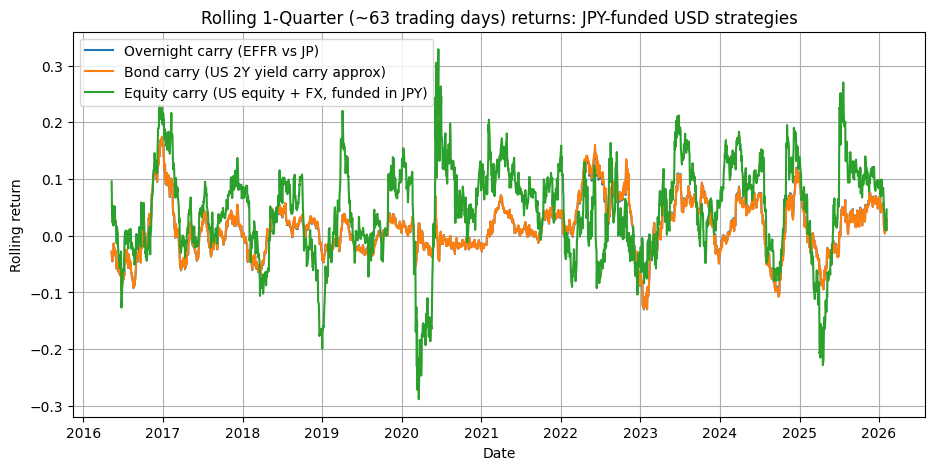

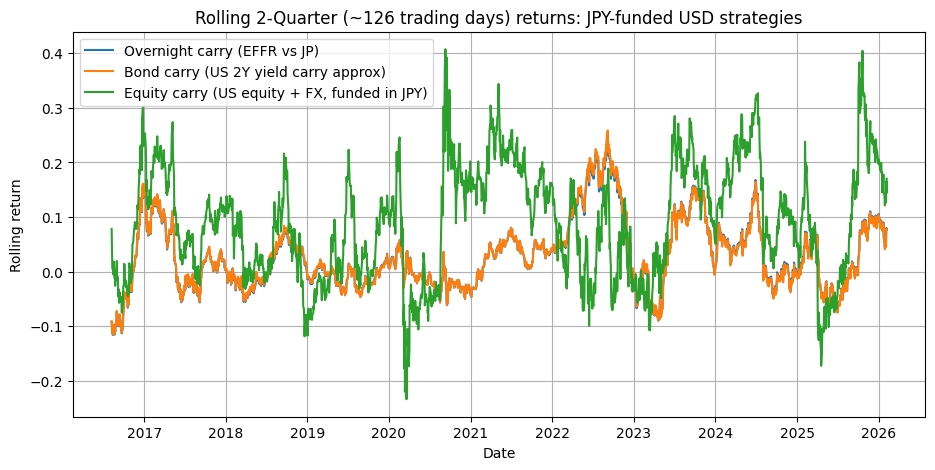

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Helpers ----------
def rolling_horizon_return(daily_simple_returns, window):
    """rolling compounded return over 'window' trading days"""
    return (1 + daily_simple_returns).rolling(window).apply(np.prod, raw=True) - 1

# ---------- Date range ----------
end = date.today()
start = end - timedelta(days=365*25 + 10)
start_s, end_s = start.isoformat(), end.isoformat()

# ---------- Pull core series ----------
fx = fred_csv("DEXJPUS", start_s, end_s)
fx.columns = ["USDJPY"]  # JPY per USD

jp = fred_csv("IRSTCI01JPM156N", start_s, end_s)
jp.columns = ["r_jp"]    # % p.a. (monthly, forward fill later)

# US overnight (for baseline comparison if you want it)
us_overnight = fred_csv("EFFR", start_s, end_s)
us_overnight.columns = ["r_us_overnight"]  # % p.a.

# ---------- Variant B input (bond yield carry approximation) ----------
# Pick ONE: 2Y or 5Y. FRED series are typically DGS2, DGS5.
us_yield = fred_csv("DGS2", start_s, end_s)   # 2-year constant maturity Treasury yield (%)
us_yield.columns = ["y_us"]                   # % p.a.

# ---------- Variant C input (equity) ----------
# If you have an equity series you can pull, put it here.
# Placeholder example: use Wilshire 5000 price index (FRED has WILL5000PR) if available.
# If this series errors, swap to another equity proxy you have access to.
spx = fred_csv("SP500", start_s, end_s)
spx.columns = ["eq"]

# ---------- Align & clean ----------
data = fx.join([jp, us_overnight, us_yield, spx], how="left")
data = data.sort_index()

# forward-fill rates and equity (equity shouldn't need ffill unless missing holidays)
data["r_jp"] = data["r_jp"].ffill()
data["r_us_overnight"] = data["r_us_overnight"].ffill()
data["y_us"] = data["y_us"].ffill()
data["eq"] = data["eq"].ffill()

# keep only rows where we have everything
data = data.dropna(subset=["USDJPY", "r_jp", "r_us_overnight", "y_us", "eq"]).copy()

# ---------- Common pieces ----------
dt = 1/360
r_jp = (data["r_jp"] / 100.0)
usd_jpy = data["USDJPY"]

# FX simple return: (S_{t+1}/S_t) - 1
fx_ret = usd_jpy.shift(-1) / usd_jpy - 1
fx_ret = fx_ret.iloc[:-1]

# ---------- Baseline (overnight cash carry) ----------
r_us = (data["r_us_overnight"] / 100.0)
carry_cash = ((1 + r_us*dt) / (1 + r_jp*dt)) - 1
carry_cash = carry_cash.iloc[:-1]

ret_baseline = (1 + fx_ret) * (1 + carry_cash) - 1
ret_baseline.name = "Overnight carry (EFFR vs JP)"

# ---------- Variant B: Bond carry (yield-carry approximation) ----------
# daily USD "bond carry" ≈ y_us/360
y_us = (data["y_us"] / 100.0)
usd_bond_carry = y_us * dt
usd_bond_carry = usd_bond_carry.iloc[:-1]

# Net carry = earn US bond carry, pay JP funding
carry_bond = ((1 + usd_bond_carry) / (1 + r_jp.iloc[:-1]*dt)) - 1
ret_bond = (1 + fx_ret) * (1 + carry_bond) - 1
ret_bond.name = "Bond carry (US 2Y yield carry approx)"

# ---------- Variant C: Equity carry ----------
# equity daily return (price return proxy)
eq = data["eq"]
eq_ret = eq.shift(-1) / eq - 1
eq_ret = eq_ret.iloc[:-1]

# Strategy: borrow JPY, hold USD equities unhedged
fund_cost = r_jp.iloc[:-1] * dt
ret_equity = (1 + fx_ret) * (1 + eq_ret) / (1 + fund_cost) - 1
ret_equity.name = "Equity carry (US equity + FX, funded in JPY)"

# ---------- Rolling horizons (Number 4) ----------
W1Q = 63
W2Q = 126

roll_1q = pd.concat([
    rolling_horizon_return(ret_baseline, W1Q),
    rolling_horizon_return(ret_bond, W1Q),
    rolling_horizon_return(ret_equity, W1Q),
], axis=1)

roll_2q = pd.concat([
    rolling_horizon_return(ret_baseline, W2Q),
    rolling_horizon_return(ret_bond, W2Q),
    rolling_horizon_return(ret_equity, W2Q),
], axis=1)

# ---------- Plot: Rolling 1Q ----------
plt.figure(figsize=(11, 5))
plt.plot(roll_1q.index, roll_1q.iloc[:,0], label=roll_1q.columns[0])
plt.plot(roll_1q.index, roll_1q.iloc[:,1], label=roll_1q.columns[1])
plt.plot(roll_1q.index, roll_1q.iloc[:,2], label=roll_1q.columns[2])
plt.title("Rolling 1-Quarter (~63 trading days) returns: JPY-funded USD strategies")
plt.xlabel("Date")
plt.ylabel("Rolling return")
plt.grid(True)
plt.legend()
plt.show()

# ---------- Plot: Rolling 2Q ----------
plt.figure(figsize=(11, 5))
plt.plot(roll_2q.index, roll_2q.iloc[:,0], label=roll_2q.columns[0])
plt.plot(roll_2q.index, roll_2q.iloc[:,1], label=roll_2q.columns[1])
plt.plot(roll_2q.index, roll_2q.iloc[:,2], label=roll_2q.columns[2])
plt.title("Rolling 2-Quarter (~126 trading days) returns: JPY-funded USD strategies")
plt.xlabel("Date")
plt.ylabel("Rolling return")
plt.grid(True)
plt.legend()
plt.show()


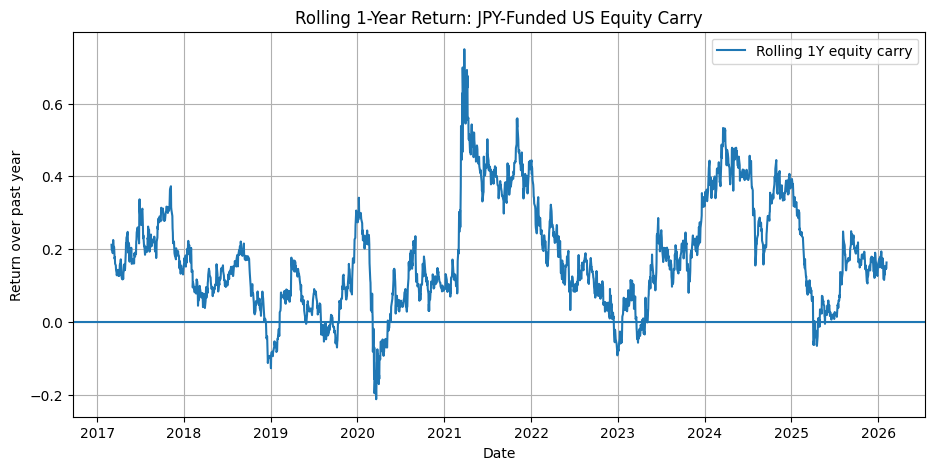

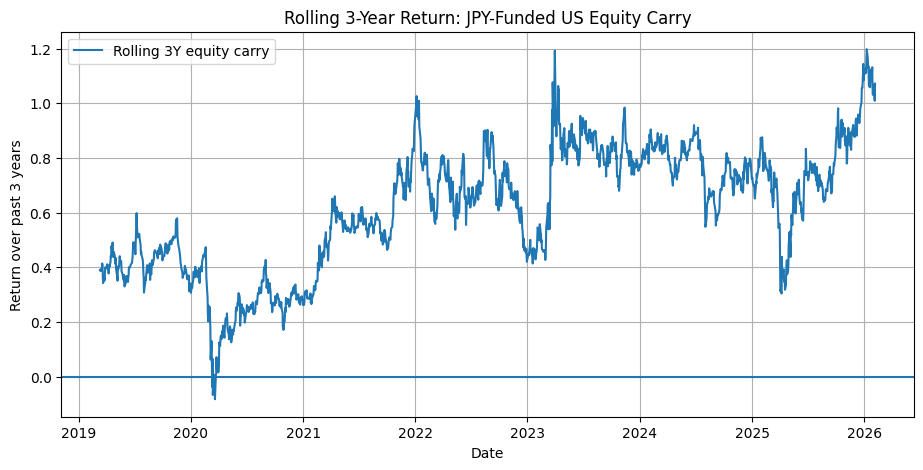

In [6]:
# ============================================================
# Rolling 1Y and 3Y Returns: JPY-Funded US Equity Carry Trade
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------------- Helper: FRED loader ----------------
def fred_csv(series_id, start_date, end_date):
    url = (
        "https://fred.stlouisfed.org/graph/fredgraph.csv"
        f"?id={series_id}&cosd={start_date}&coed={end_date}"
    )
    df = pd.read_csv(url)
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    df = df.set_index("observation_date")
    df = df.replace(".", np.nan)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

# ---------------- Helper: rolling horizon return ----------------
def rolling_horizon_return(daily_returns, window):
    return (1 + daily_returns).rolling(window).apply(np.prod, raw=True) - 1

# ---------------- Date range ----------------
end = date.today()
start = end - timedelta(days=365*10)   # long enough for 3Y windows
start_s, end_s = start.isoformat(), end.isoformat()

# ---------------- Pull data ----------------
# FX: USDJPY (JPY per USD)
fx = fred_csv("DEXJPUS", start_s, end_s)
fx.columns = ["USDJPY"]

# JPY funding rate (short-term)
jp = fred_csv("IRSTCI01JPM156N", start_s, end_s)
jp.columns = ["r_jp"]  # % p.a.

# US equity proxy (price return)
eq = fred_csv("SP500", start_s, end_s)
eq.columns = ["eq"]

# ---------------- Align & clean ----------------
data = fx.join([jp, eq], how="left").sort_index()
data["r_jp"] = data["r_jp"].ffill()
data["eq"] = data["eq"].ffill()
data = data.dropna()

# ---------------- Daily returns ----------------
dt = 1 / 360

# FX return
fx_ret = data["USDJPY"].shift(-1) / data["USDJPY"] - 1

# Equity return (price return proxy)
eq_ret = data["eq"].shift(-1) / data["eq"] - 1

# JPY funding cost
fund_cost = (data["r_jp"] / 100.0) * dt

# Equity carry return (JPY-funded, FX unhedged)
ret_equity = (1 + eq_ret) * (1 + fx_ret) / (1 + fund_cost) - 1
ret_equity = ret_equity.dropna()

# ---------------- Rolling windows ----------------
W_1Y = 252
W_3Y = 252 * 3

roll_1y = rolling_horizon_return(ret_equity, W_1Y)
roll_3y = rolling_horizon_return(ret_equity, W_3Y)

# ---------------- Plot: Rolling 1Y ----------------
plt.figure(figsize=(11, 5))
plt.plot(roll_1y.index, roll_1y, label="Rolling 1Y equity carry")
plt.axhline(0)
plt.title("Rolling 1-Year Return: JPY-Funded US Equity Carry")
plt.xlabel("Date")
plt.ylabel("Return over past year")
plt.grid(True)
plt.legend()
plt.show()

# ---------------- Plot: Rolling 3Y ----------------
plt.figure(figsize=(11, 5))
plt.plot(roll_3y.index, roll_3y, label="Rolling 3Y equity carry")
plt.axhline(0)
plt.title("Rolling 3-Year Return: JPY-Funded US Equity Carry")
plt.xlabel("Date")
plt.ylabel("Return over past 3 years")
plt.grid(True)
plt.legend()
plt.show()


Equity carry Sharpe (full sample): 0.86


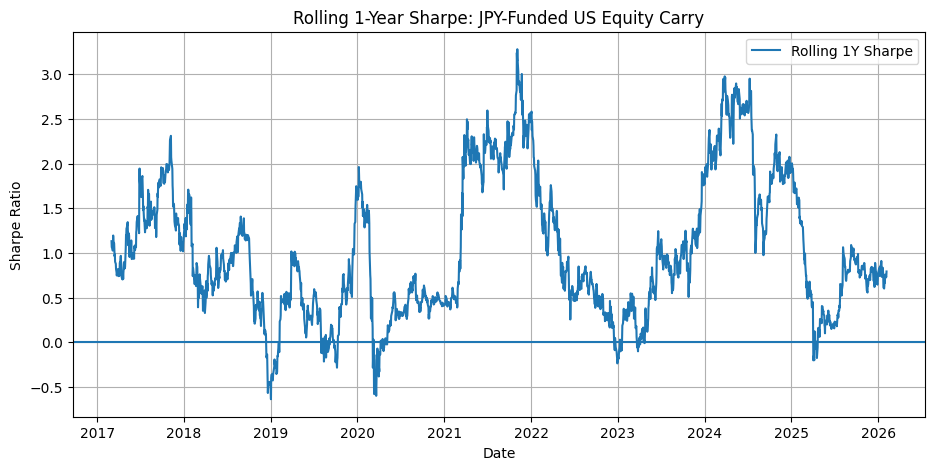

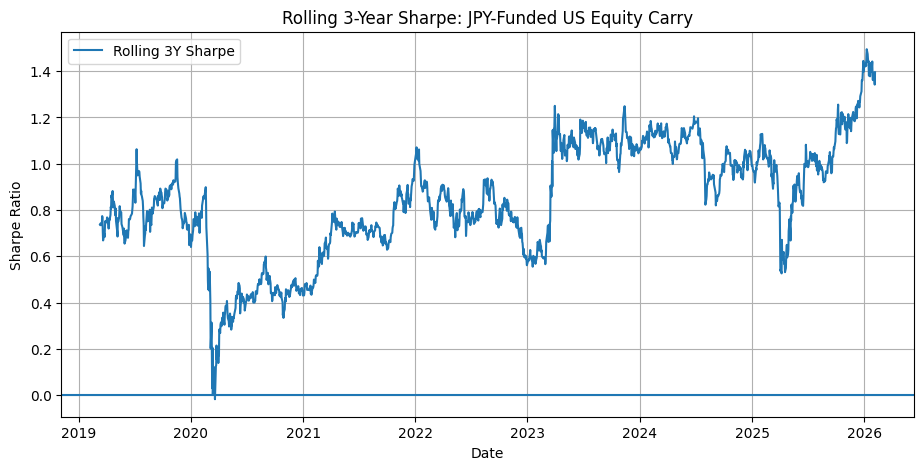

In [7]:
def sharpe_ratio(daily_returns, periods_per_year=252):
    mean_ret = daily_returns.mean()
    vol = daily_returns.std()
    sharpe = (mean_ret / vol) * np.sqrt(periods_per_year)
    return sharpe

overall_sharpe = sharpe_ratio(ret_equity)
print(f"Equity carry Sharpe (full sample): {overall_sharpe:.2f}")

rolling_1y_sharpe = (
    ret_equity
    .rolling(252)
    .apply(lambda x: sharpe_ratio(pd.Series(x)), raw=False)
)

rolling_3y_sharpe = (
    ret_equity
    .rolling(252 * 3)
    .apply(lambda x: sharpe_ratio(pd.Series(x)), raw=False)
)


import matplotlib.pyplot as plt

plt.figure(figsize=(11, 5))
plt.plot(rolling_1y_sharpe.index, rolling_1y_sharpe, label="Rolling 1Y Sharpe")
plt.axhline(0)
plt.title("Rolling 1-Year Sharpe: JPY-Funded US Equity Carry")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(11, 5))
plt.plot(rolling_3y_sharpe.index, rolling_3y_sharpe, label="Rolling 3Y Sharpe")
plt.axhline(0)
plt.title("Rolling 3-Year Sharpe: JPY-Funded US Equity Carry")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.show()


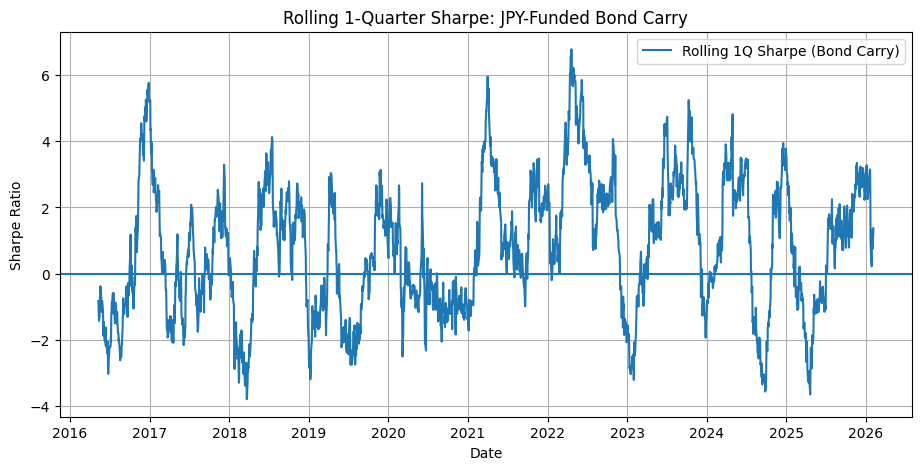

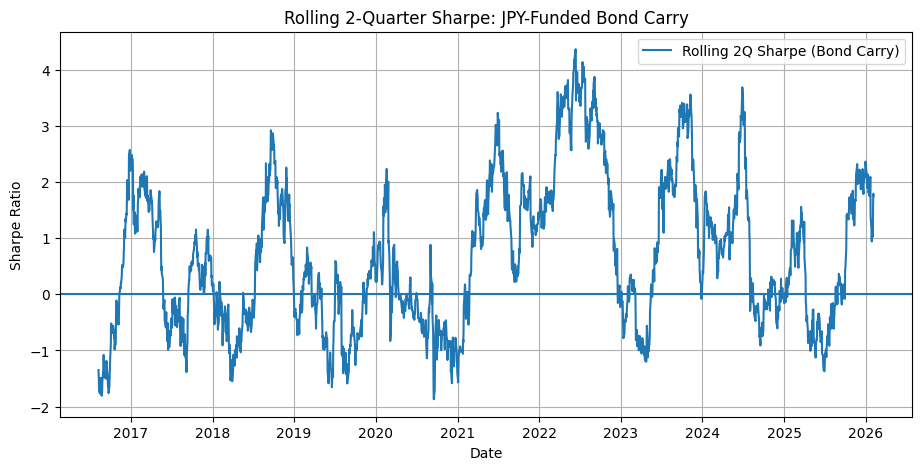

In [8]:
import numpy as np
import pandas as pd

def sharpe_ratio(daily_returns, periods_per_year=252):
    mu = daily_returns.mean()
    sigma = daily_returns.std()
    return (mu / sigma) * np.sqrt(periods_per_year)

W_1Q = 63

rolling_1q_sharpe_bond = (
    ret_bond
    .rolling(W_1Q)
    .apply(lambda x: sharpe_ratio(pd.Series(x)), raw=False)
)

W_2Q = 126

rolling_2q_sharpe_bond = (
    ret_bond
    .rolling(W_2Q)
    .apply(lambda x: sharpe_ratio(pd.Series(x)), raw=False)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(11, 5))
plt.plot(rolling_1q_sharpe_bond.index, rolling_1q_sharpe_bond, label="Rolling 1Q Sharpe (Bond Carry)")
plt.axhline(0)
plt.title("Rolling 1-Quarter Sharpe: JPY-Funded Bond Carry")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(11, 5))
plt.plot(rolling_2q_sharpe_bond.index, rolling_2q_sharpe_bond, label="Rolling 2Q Sharpe (Bond Carry)")
plt.axhline(0)
plt.title("Rolling 2-Quarter Sharpe: JPY-Funded Bond Carry")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
import pandas as pd
import numpy as np

# ---------- helpers ----------
def annualized_stats(daily_returns, periods_per_year=252):
    mean_ann = daily_returns.mean() * periods_per_year
    vol_ann = daily_returns.std() * np.sqrt(periods_per_year)
    sharpe = mean_ann / vol_ann
    return mean_ann, vol_ann, sharpe

def avg_rolling_sharpe(daily_returns, window):
    rolling_sharpe = (
        daily_returns
        .rolling(window)
        .apply(lambda x: (x.mean() / x.std()) * np.sqrt(252), raw=False)
    )
    return rolling_sharpe.mean()

# ---------- horizons ----------
W_1Q = 63
W_2Q = 126
W_1Y = 252
W_3Y = 252 * 3

# ---------- build table ----------
rows = []

for name, series in [
    ("Bond carry", ret_bond),
    ("Equity carry", ret_equity)
]:
    mean_ann, vol_ann, sharpe_full = annualized_stats(series)

    rows.append({
        "Strategy": name,
        "Ann. Return": mean_ann,
        "Ann. Volatility": vol_ann,
        "Sharpe (full sample)": sharpe_full,
        "Avg Rolling 1Q Sharpe": avg_rolling_sharpe(series, W_1Q),
        "Avg Rolling 2Q Sharpe": avg_rolling_sharpe(series, W_2Q),
        "Avg Rolling 1Y Sharpe": avg_rolling_sharpe(series, W_1Y),
        "Avg Rolling 3Y Sharpe": avg_rolling_sharpe(series, W_3Y),
    })

summary_table = pd.DataFrame(rows).set_index("Strategy")

summary_table = summary_table.round(2)
summary_table


,Ann. Return,Ann. Volatility,Sharpe (full sample),Avg Rolling 1Q Sharpe,Avg Rolling 2Q Sharpe,Avg Rolling 1Y Sharpe,Avg Rolling 3Y Sharpe
Strategy,,,,,,,
Bond carry,0.05,0.09,0.59,0.77,0.68,0.63,0.66
Equity carry,0.18,0.21,0.86,1.34,1.17,1.02,0.84


In [10]:
"""
Across the full sample, both bond and equity carry trades funded in JPY generate positive excess returns, but their risk-adjusted performance differs meaningfully across horizons. 
Bond carry exhibits moderate annualized returns with relatively lower volatility, resulting in a stable but capped Sharpe ratio. 
In contrast, equity carry delivers higher average returns but with substantially greater volatility. When evaluated over short horizons (1–2 quarters), rolling Sharpe ratios for both strategies are low and unstable, reflecting the dominance of FX fluctuations and macro regime shifts. 
However, as the evaluation window extends to one and especially three years, equity carry Sharpe ratios increase materially, indicating that the equity risk premium requires time to dominate funding costs and short-term volatility.
"""

'\nAcross the full sample, both bond and equity carry trades funded in JPY generate positive excess returns, but their risk-adjusted performance differs meaningfully across horizons. \nBond carry exhibits moderate annualized returns with relatively lower volatility, resulting in a stable but capped Sharpe ratio. \nIn contrast, equity carry delivers higher average returns but with substantially greater volatility. When evaluated over short horizons (1–2 quarters), rolling Sharpe ratios for both strategies are low and unstable, reflecting the dominance of FX fluctuations and macro regime shifts. \nHowever, as the evaluation window extends to one and especially three years, equity carry Sharpe ratios increase materially, indicating that the equity risk premium requires time to dominate funding costs and short-term volatility.\n'

In [11]:
# ============================================================
# CHF-Funded USD Carry Trade (Daily Returns)
# ============================================================

# Pull CHF FX
fx_chf = fred_csv("DEXSZUS", start_s, end_s)
fx_chf.columns = ["USDCHF"]   # CHF per USD

# Pull Swiss short rate
ch_rate = fred_csv("IRSTCI01CHM156N", start_s, end_s)
ch_rate.columns = ["r_chf"]   # % p.a.

# Join with US rate
data_chf = fx_chf.join([us_overnight, ch_rate], how="left").sort_index()

data_chf["r_chf"] = data_chf["r_chf"].ffill()
data_chf["r_us_overnight"] = data_chf["r_us_overnight"].ffill()

data_chf = data_chf.dropna()

dt = 1/360

# FX return
fx_ret_chf = data_chf["USDCHF"].shift(-1) / data_chf["USDCHF"] - 1

# Interest carry
r_us = data_chf["r_us_overnight"] / 100.0
r_chf = data_chf["r_chf"] / 100.0

carry_chf = ((1 + r_us*dt) / (1 + r_chf*dt)) - 1

# Total return
ret_chf_carry = (1 + fx_ret_chf) * (1 + carry_chf) - 1
ret_chf_carry = ret_chf_carry.dropna()


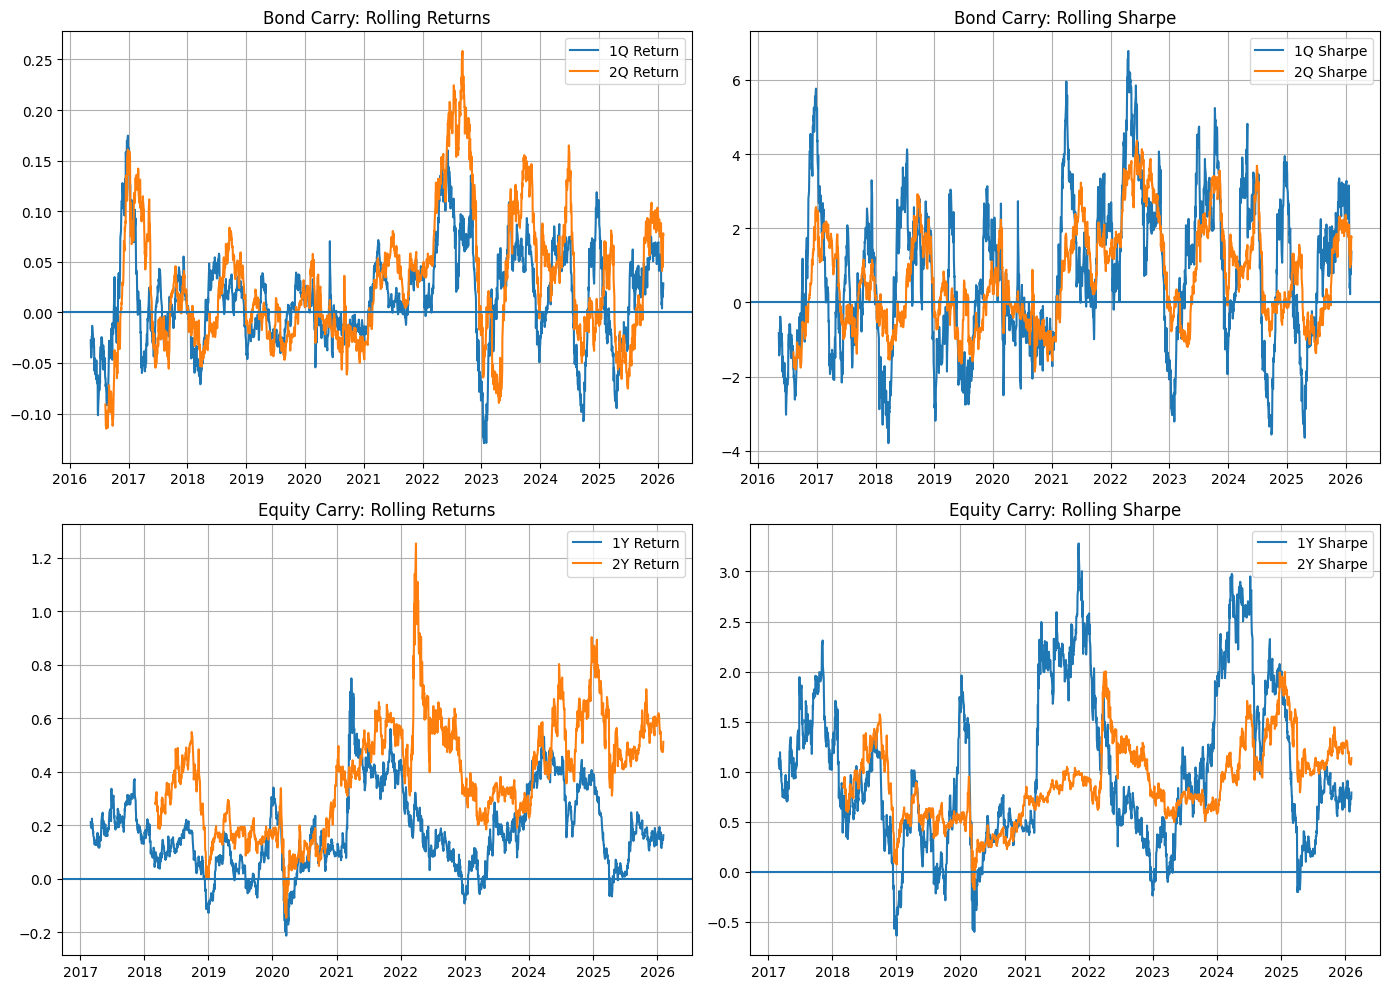

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Helpers ----------------

def rolling_return(daily_returns, window):
    return (1 + daily_returns).rolling(window).apply(np.prod, raw=True) - 1

def rolling_sharpe(daily_returns, window):
    return (
        daily_returns
        .rolling(window)
        .apply(lambda x: (x.mean() / x.std()) * np.sqrt(252), raw=False)
    )

# ---------------- Windows ----------------

W_1Q = 63
W_2Q = 126

W_1Y = 252
W_2Y = 252 * 2

# ---------------- Bond Carry ----------------

bond_1q_ret = rolling_return(ret_bond, W_1Q)
bond_2q_ret = rolling_return(ret_bond, W_2Q)

bond_1q_sharpe = rolling_sharpe(ret_bond, W_1Q)
bond_2q_sharpe = rolling_sharpe(ret_bond, W_2Q)

# ---------------- Equity Carry ----------------

equity_1y_ret = rolling_return(ret_equity, W_1Y)
equity_2y_ret = rolling_return(ret_equity, W_2Y)

equity_1y_sharpe = rolling_sharpe(ret_equity, W_1Y)
equity_2y_sharpe = rolling_sharpe(ret_equity, W_2Y)

# ============================================================
# PLOTTING
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---------------- Bond Returns ----------------
axes[0, 0].plot(bond_1q_ret.index, bond_1q_ret, label="1Q Return")
axes[0, 0].plot(bond_2q_ret.index, bond_2q_ret, label="2Q Return")
axes[0, 0].axhline(0)
axes[0, 0].set_title("Bond Carry: Rolling Returns")
axes[0, 0].legend()
axes[0, 0].grid(True)

# ---------------- Bond Sharpe ----------------
axes[0, 1].plot(bond_1q_sharpe.index, bond_1q_sharpe, label="1Q Sharpe")
axes[0, 1].plot(bond_2q_sharpe.index, bond_2q_sharpe, label="2Q Sharpe")
axes[0, 1].axhline(0)
axes[0, 1].set_title("Bond Carry: Rolling Sharpe")
axes[0, 1].legend()
axes[0, 1].grid(True)

# ---------------- Equity Returns ----------------
axes[1, 0].plot(equity_1y_ret.index, equity_1y_ret, label="1Y Return")
axes[1, 0].plot(equity_2y_ret.index, equity_2y_ret, label="2Y Return")
axes[1, 0].axhline(0)
axes[1, 0].set_title("Equity Carry: Rolling Returns")
axes[1, 0].legend()
axes[1, 0].grid(True)

# ---------------- Equity Sharpe ----------------
axes[1, 1].plot(equity_1y_sharpe.index, equity_1y_sharpe, label="1Y Sharpe")
axes[1, 1].plot(equity_2y_sharpe.index, equity_2y_sharpe, label="2Y Sharpe")
axes[1, 1].axhline(0)
axes[1, 1].set_title("Equity Carry: Rolling Sharpe")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
